# SQL Benchmarking

This notebook runs a series of benchmarking SQL queries on TPCDS data, at various scales, stored as hive parquet, apache iceberg and apache hudi athena databases. Code for the creation of these databases can be found elsewhere in this repository.

## Setup

First, load AWS credentials from a `.env` file.

In [1]:
%load_ext dotenv
%dotenv

Here we load the required libraries / functions and set sensible defaults. For instance, `total_iterations` controls the number of times a query is run before an average is taken. To run a subset of the SQL files, alter the `limit` variable.

In [2]:
import os

import awswrangler as wr
from benchmark_functions import get_all_query_stats

os.environ["AWS_DEFAULT_REGION"] = "eu-west-1"

wr.config.workgroup = "AthenaWorkGroupIceberg"

limit = (0, 100)
total_iterations = 4


## Scale = 3000 & partitioned

First run the SQL queries for our base parquet-hive database, `tpcds_3000_partitioned`.

In [3]:
hive_results = get_all_query_stats(
    "tpcds_3000_partitioned",
    limit=limit,
    total_iterations=total_iterations,
    sql_directory="sql"
)
hive_results.to_csv('results/tpcds_3000_partitioned.csv')

Do the same for our iceberg database.

In [3]:
iceberg_results = get_all_query_stats(
    "tpcds_iceberg_3000_partitioned",
    limit=limit,
    total_iterations=total_iterations,
    sql_directory="sql"
)
iceberg_results.to_csv('results/tpcds_iceberg_3000_partitioned.csv')

We'll now use the results to compare iceberg against parquet.

In [3]:
# import pandas as pd
# hive_results = pd.read_csv('results/tpcds_3000_partitioned.csv', index_col=0)
# iceberg_results = pd.read_csv('results/tpcds_iceberg_3000_partitioned.csv', index_col=0)
multiplier_comparison = (iceberg_results / hive_results).transpose()


In [8]:
multiplier_means = multiplier_comparison.mean()
iceberg_multiplier_data_mean = multiplier_means.loc["DataScannedInBytes"]
iceberg_multiplier_execution_mean = multiplier_means.loc["TotalExecutionTimeInMillis"]
iceberg_multiplier_queue_mean = multiplier_means.loc["QueryQueueTimeInMillis"]
iceberg_multiplier_planning_mean = multiplier_means.loc["QueryPlanningTimeInMillis"]
iceberg_multiplier_processing_mean = multiplier_means.loc["ServiceProcessingTimeInMillis"]
print(iceberg_multiplier_data_mean)
print(iceberg_multiplier_execution_mean)
print(iceberg_multiplier_queue_mean)
print(iceberg_multiplier_planning_mean)
print(iceberg_multiplier_processing_mean)


0.873945314579208
1.154171792084174
1.1701538040621196
0.5139490256720938
1.0220658684083876


In [5]:
multiplier_means = multiplier_comparison.mean()
iceberg_multiplier_data_mean = multiplier_means.loc["DataScannedInBytes"]
iceberg_multiplier_execution_mean = multiplier_means.loc["TotalExecutionTimeInMillis"]
print(iceberg_multiplier_data_mean)
print(iceberg_multiplier_execution_mean)

0.8016970225673333
1.1342974070769969


First we'll check to see whether the queries scan more or less data when run on iceberg compared to parquet-hive.

/var/folders/s3/xs56ggfx1bn13xz8j914dvsm0000gp/T/ipykernel_82725/1159386339.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  data_scanned_plot.set_xticklabels(data_xlabels)


<Axes: title={'center': 'Amount of data scanned in comparison to Parquet'}, xlabel='Multiplier', ylabel='Query'>

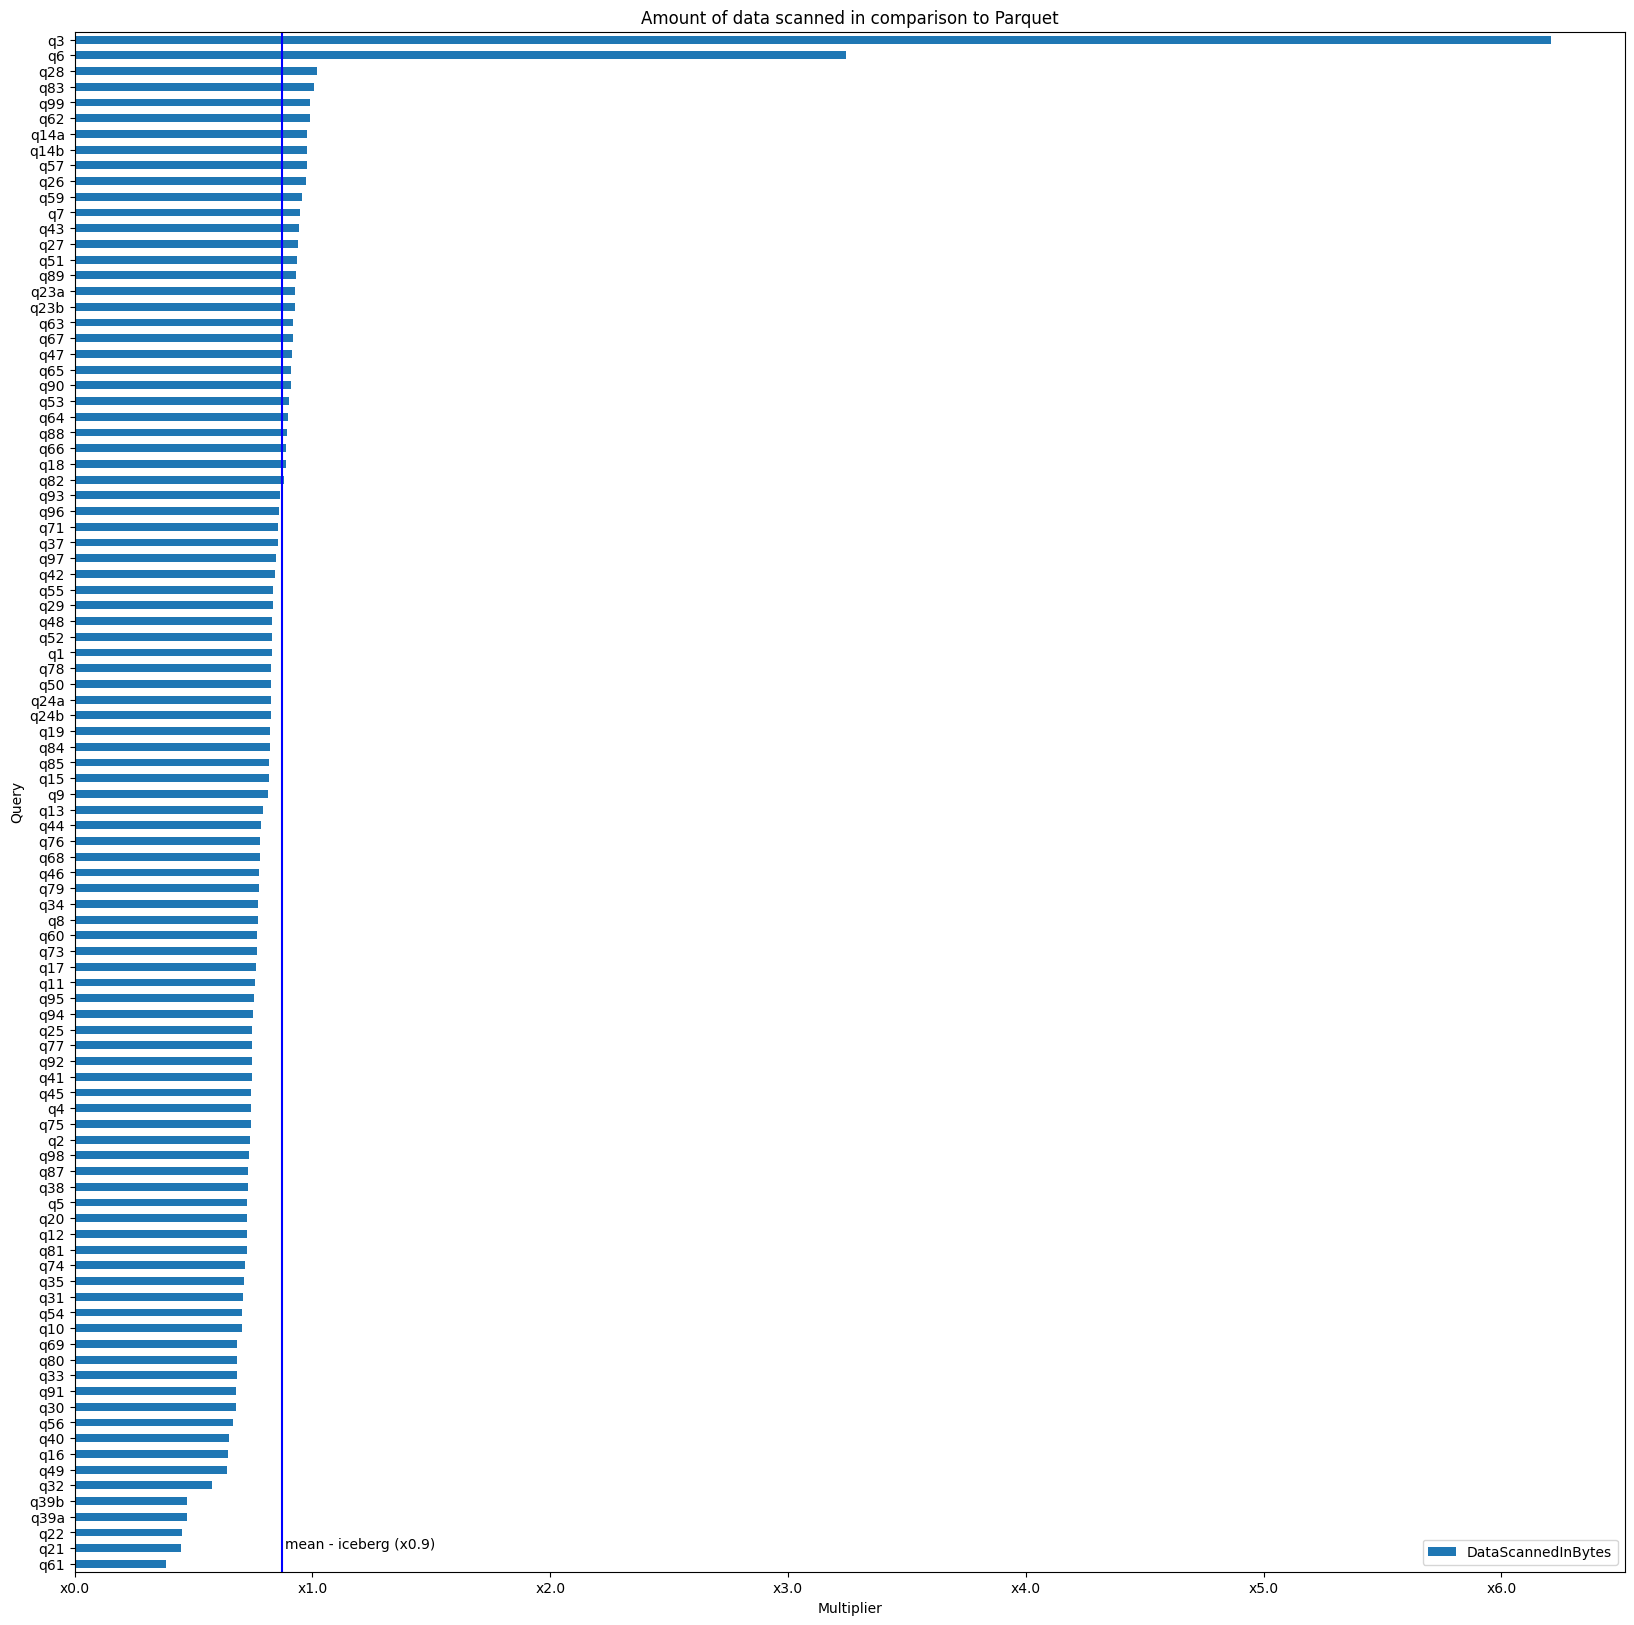

In [6]:
data_scanned_plot = multiplier_comparison\
    .sort_values(by=['DataScannedInBytes']) \
    .plot(
        y=['DataScannedInBytes'],
        kind='barh',
        figsize=(20,20),
        xlabel="Multiplier",
        ylabel="Query",
        title="Amount of data scanned in comparison to Parquet",
    )

data_xlabels = [f"x{round(x, 2)}" for x in data_scanned_plot.get_xticks()]

data_scanned_plot.set_xticklabels(data_xlabels)

data_scanned_plot.axvline(iceberg_multiplier_data_mean, color="blue")
data_scanned_plot.text(iceberg_multiplier_data_mean + 0.01, 1,f'mean - iceberg (x{round(iceberg_multiplier_data_mean, 1)})',rotation=0)

data_scanned_plot

Similarly, let's see how the total execution time compares between Iceberg and parquet-hive.

/var/folders/s3/xs56ggfx1bn13xz8j914dvsm0000gp/T/ipykernel_82725/2898395262.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  execution_time_plot.set_xticklabels(execution_xlabels)


<Axes: title={'center': 'Total execution time in comparison to Parquet'}, xlabel='Multiplier', ylabel='Query'>

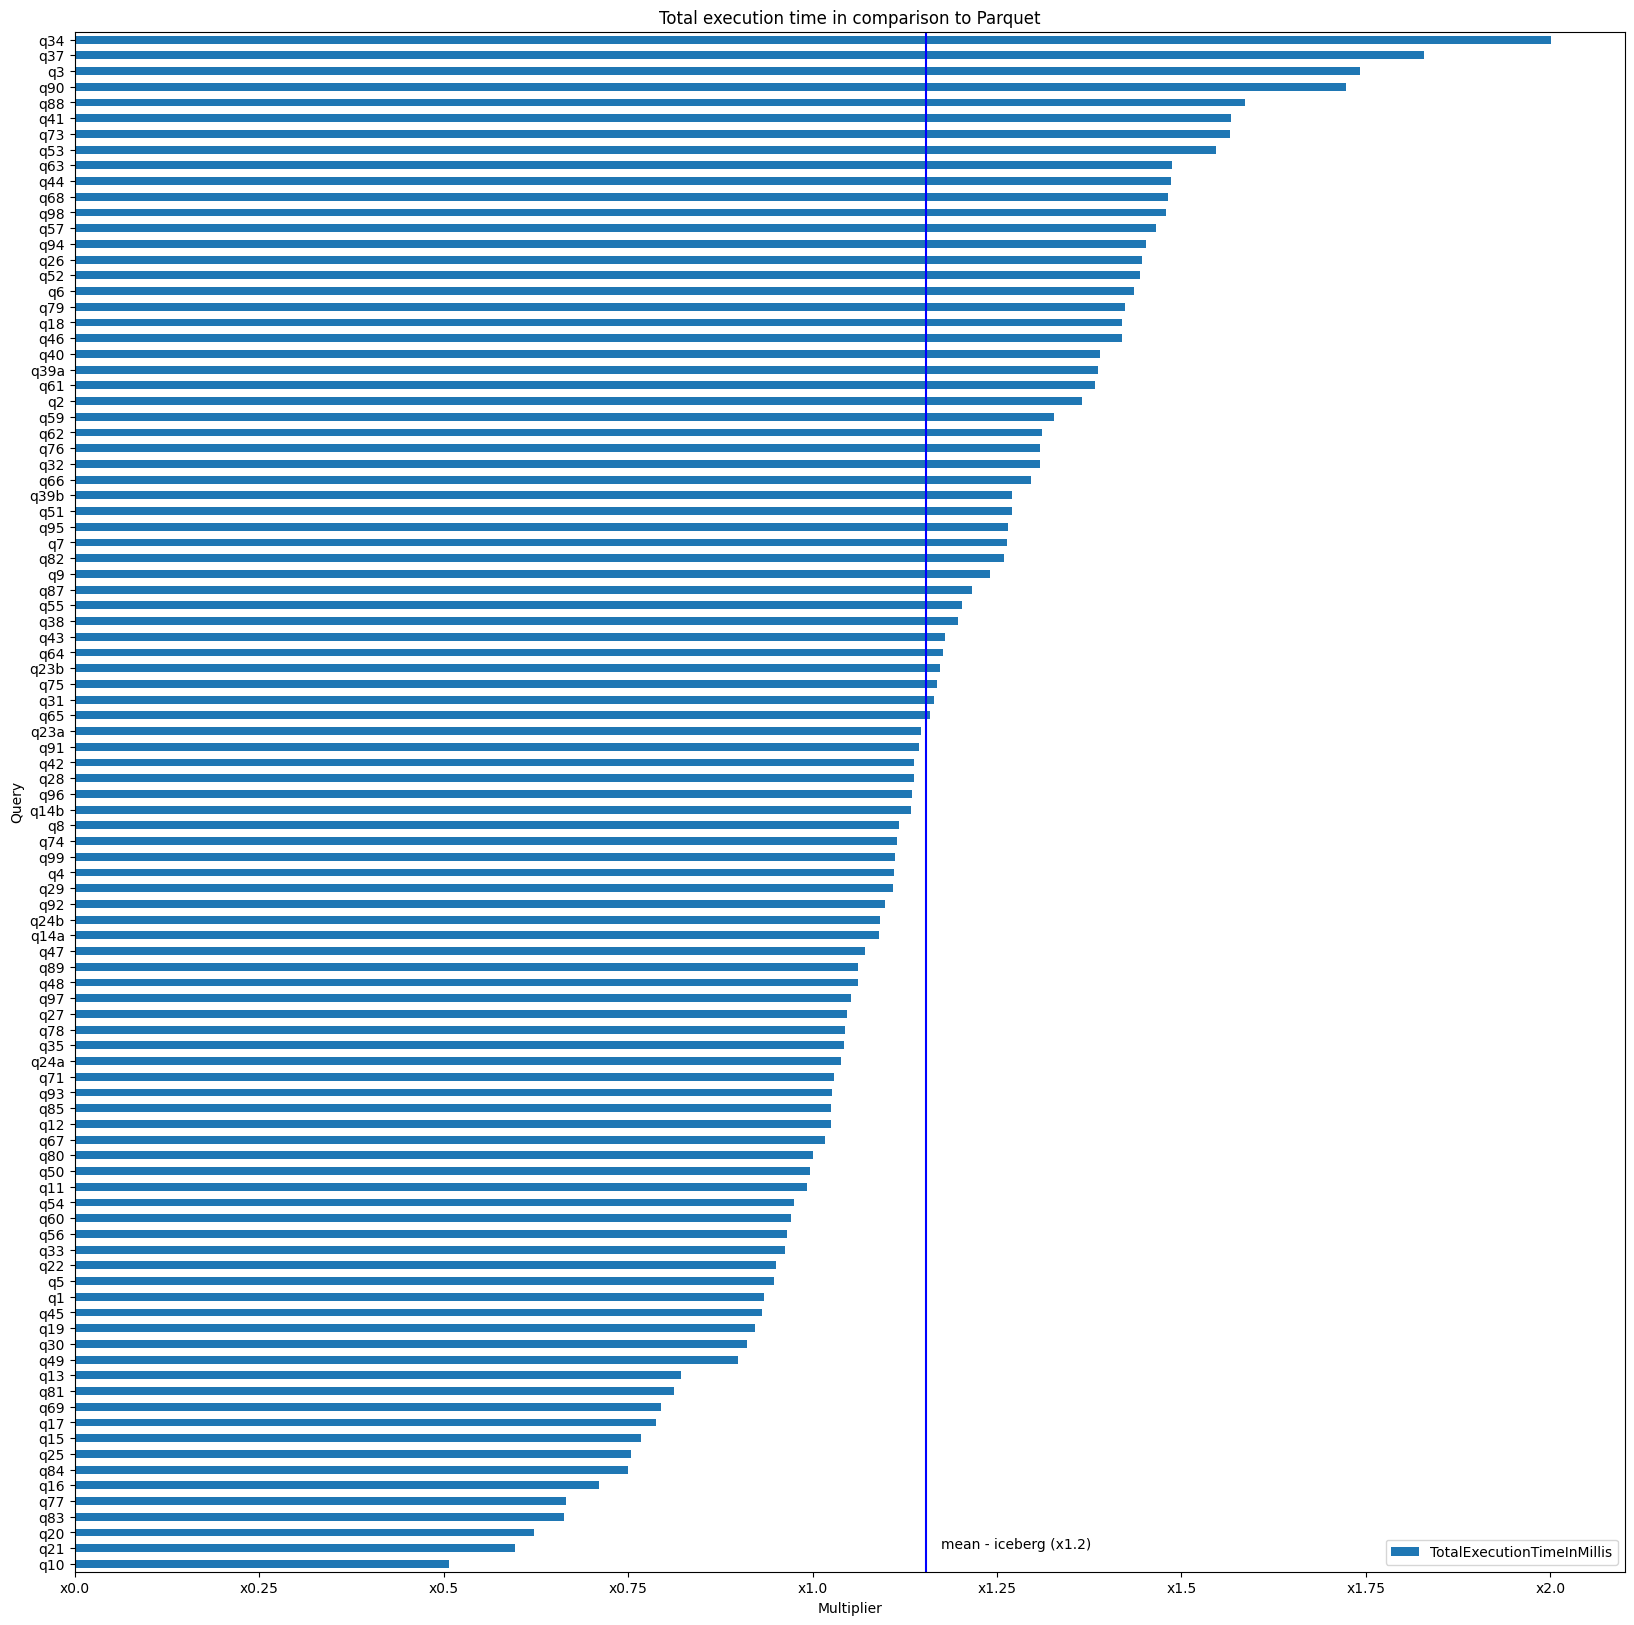

In [7]:
execution_time_plot = multiplier_comparison \
    .sort_values(by=['TotalExecutionTimeInMillis']) \
    .plot(
        y=['TotalExecutionTimeInMillis'],
        kind='barh',
        figsize=(20,20),
        xlabel="Multiplier",
        ylabel="Query",
        title="Total execution time in comparison to Parquet",
    )

execution_xlabels = [f"x{round(x, 2)}" for x in execution_time_plot.get_xticks()]

execution_time_plot.set_xticklabels(execution_xlabels)

execution_time_plot.axvline(iceberg_multiplier_execution_mean, color="blue")
execution_time_plot.text(iceberg_multiplier_execution_mean + 0.02, 1,f'mean - iceberg (x{round(iceberg_multiplier_execution_mean, 1)})',rotation=0)

execution_time_plot
